In [17]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy import signal

import os
from glob import glob
import matplotlib.pyplot as plt


Folder Paths

In [18]:
greenPath = './ppg_GREEN/'
redPath = './ppg_RED/'
irPath = './ppg_IR/'


BandPass Filter

In [19]:
# BandPass Filter Parameters

sampling_freq = 100 # Hz

lowcut = 0.5                         # Lower Cutoff Frequency in Hz
highcut = 35.0                       # Higher Cutoff Frequency in Hz
nyquist_freq = 0.5 * sampling_freq   # Nyquist frequency in Hz
order = 4                            # Filter order

# Design Bandpass Filter
b, a = signal.butter(order, [lowcut / nyquist_freq, highcut / nyquist_freq], btype='band')

BandPass Filter : AC Component Calculation

BANDPASS

AC Component of ./ppg_GREEN/green2_SB.csv : 71.83433203444554
AC Component of ./ppg_GREEN/green4_AR.csv : 58.18900613336727
AC Component of ./ppg_GREEN/green2_AR.csv : 21.275531301878786
AC Component of ./ppg_GREEN/green4_SB.csv : 40.68292338234967
AC Component of ./ppg_GREEN/green1_SB.csv : 29.073931987017367
AC Component of ./ppg_GREEN/green5_AR.csv : 47.36919706551459
AC Component of ./ppg_GREEN/green3_SB.csv : 39.094964008128585
AC Component of ./ppg_GREEN/green1_AR.csv : 8.982103450864589
AC Component of ./ppg_GREEN/green5_SB.csv : 36.83184788556094
AC Component of ./ppg_GREEN/green3_AR.csv : 22.569711417507776
---------------------------------------------------
---------------------------------------------------
Average AC Component for  SB is : 43.50359985950042
Average AC Component for  AR is : 31.677109873826602
---------------------------------------------------
Average AC Component of Trials using Bandpass is : 37.59035486666352


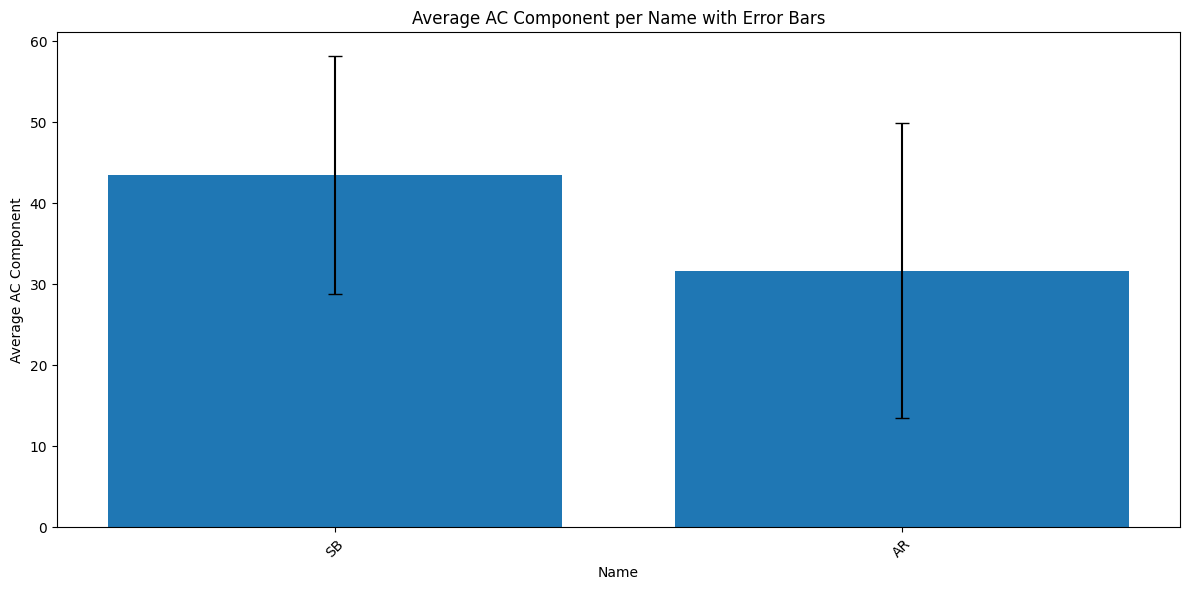

In [20]:
# Average AC Component of Trials
overallAvgAC = 0
numOfFiles = 0
color = ''

print("BANDPASS\n")

subjects = {}

for file in glob(greenPath + '*.csv'):
    color = file.split('_')[0]
    name = file.split('_')[2]
    name = name.split('.')[0]

    numOfFiles += 1
    ppg_data = pd.read_csv(file)
    noisy_ppgOne = ppg_data["PPG1"].values
    # Apply BandPass Filter to noisy ECG Signal
    filtered_ppg_1 = signal.filtfilt(b, a, noisy_ppgOne)

    # Baseline Correction
    baseline_ppg_1 = signal.medfilt(filtered_ppg_1, kernel_size=51)  # Apply a median filter as a baseline
    corrected_ppg_1 = filtered_ppg_1 - baseline_ppg_1

    # Smoothing
    smoothed_ppg_1 = signal.savgol_filter(corrected_ppg_1, window_length=51, polyorder=3)

    # Remove the DC Component
    dc_component = np.mean(smoothed_ppg_1)
    ppg_ac= smoothed_ppg_1 - dc_component

    # Calculate the AC Component
    peaks, _ = find_peaks(ppg_ac)  # Adjust height threshold as needed
    troughs, _ = find_peaks(-ppg_ac)  # Detect troughs by inverting signal
    ac_component = ppg_ac[peaks].mean() - ppg_ac[troughs].mean()

    # Add to People Dictionary
    if name not in subjects.keys():
        subjects[name] = []
    
    # Add the number to the list associated with the name
    subjects[name].append(ac_component)

    # Add to avg
    overallAvgAC += ac_component

    # Print the AC Component for trial
    print(f'AC Component of {file} : {ac_component}')

print('---------------------------------------------------')
print('---------------------------------------------------')
for i,j in subjects.items():
    avgAC = average = sum(j) / len(j)
    print("Average AC Component for ", i, "is :", avgAC)

print('---------------------------------------------------')
print(f'Average AC Component of Trials using Bandpass is : {overallAvgAC / numOfFiles}')



# Create a dictionary to store the average AC components and standard deviations for each name
avg_ac_components = {}
std_dev_ac_components = {}

for name, ac_list in subjects.items():
    avg_ac_components[name] = sum(ac_list) / len(ac_list)
    std_dev_ac_components[name] = np.std(ac_list)

# Create a bar graph with error bars
names = list(avg_ac_components.keys())
ac_values = list(avg_ac_components.values())
std_dev_values = list(std_dev_ac_components.values())

plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.bar(names, ac_values, yerr=std_dev_values, capsize=5)
plt.xlabel('Name')
plt.ylabel('Average AC Component')
plt.title('Average AC Component per Name with Error Bars')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()



BandPass Filter : Perfusion Index Calculation

BANDPASS

---------------------------------------------------
---------------------------------------------------
Average Perfusion Component for  SB is : 374.5851886928683
Average Perfusion Component for  AR is : 430.65944912996883
---------------------------------------------------
Average Perfusion Component of Trials using Bandpass is : 402.6223189114185


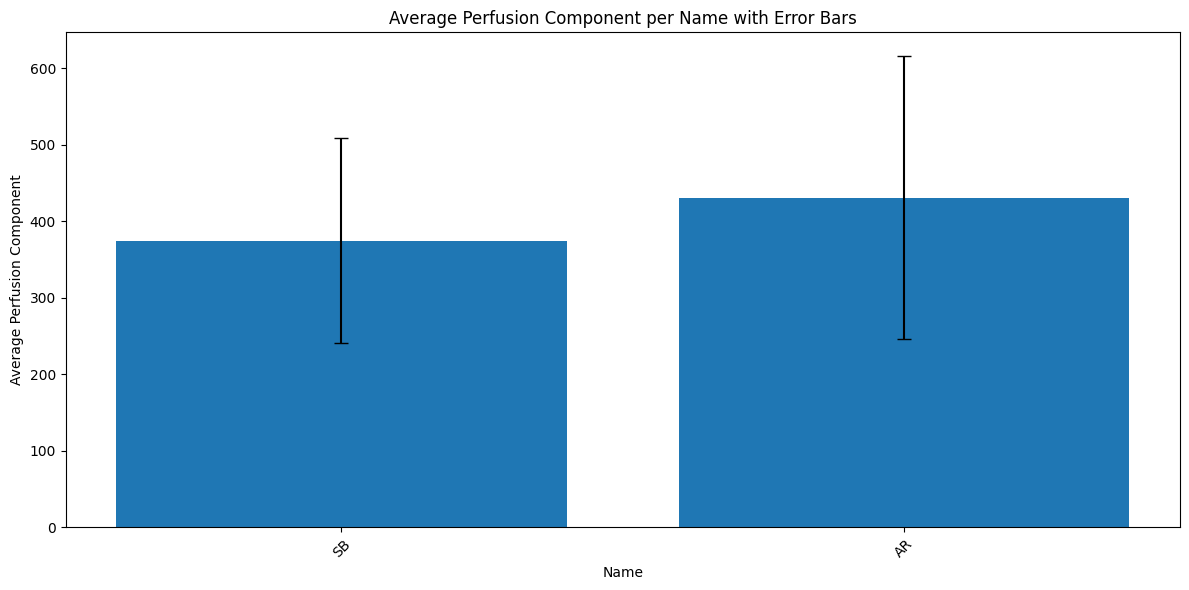

In [22]:
# Average Perfusion Index of Trials
overallAvgPerfusion = 0
numOfFiles = 0

subjects = {}

print("BANDPASS\n")

for file in glob(greenPath + '*.csv'):
    color = file.split('_')[0]
    name = file.split('_')[2]
    name = name.split('.')[0]

    numOfFiles += 1
    ppg_data = pd.read_csv(file)
    noisy_ppgOne = ppg_data["PPG1"].values
    # Apply BandPass Filter to noisy ECG Signal
    filtered_ppg_1 = signal.filtfilt(b, a, noisy_ppgOne)

    # Baseline Correction
    baseline_ppg_1 = signal.medfilt(filtered_ppg_1, kernel_size=51)  # Apply a median filter as a baseline
    corrected_ppg_1 = filtered_ppg_1 - baseline_ppg_1

    # Smoothing
    smoothed_ppg_1 = signal.savgol_filter(corrected_ppg_1, window_length=51, polyorder=3)

    # Find peaks and troughs-------------------------------------------------------------------------------
    peaks, _ = find_peaks(smoothed_ppg_1)  # Adjust height threshold as needed
    troughs, _ = find_peaks(-smoothed_ppg_1)  # Detect troughs by inverting signal

    # Calculate Pulse Amplitude
    if len(peaks) > 0 and len(troughs) > 0:
        pulse_amplitude = smoothed_ppg_1[peaks].mean() - smoothed_ppg_1[troughs].mean()
    else:
        pulse_amplitude = np.nan

    # Calculate Baseline Amplitude
    baseline_amplitude = smoothed_ppg_1.mean()

    # Calculate Perfusion Index
    if not np.isnan(pulse_amplitude) and not np.isnan(baseline_amplitude):
        perfusion_index = (pulse_amplitude / baseline_amplitude) * 100
    else:
        perfusion_index = np.nan

    # Add to People Dictionary
    if name not in subjects.keys():
        subjects[name] = []
    
    # Add the number to the list associated with the name
    subjects[name].append(perfusion_index)

    # Add to avg
    overallAvgPerfusion += perfusion_index

print('---------------------------------------------------')
print('---------------------------------------------------')
for i,j in subjects.items():
    avgPerfusion = average = sum(j) / len(j)
    print("Average Perfusion Component for ", i, "is :", avgPerfusion)

print('---------------------------------------------------')
print(f'Average Perfusion Component of Trials using Bandpass is : {overallAvgPerfusion / numOfFiles}')


# Create a dictionary to store the average AC components and standard deviations for each name
avg_perfusion_components = {}
std_dev_perfusion_components = {}

for name, p_list in subjects.items():
    avg_perfusion_components[name] = sum(p_list) / len(p_list)
    std_dev_perfusion_components[name] = np.std(p_list)

# Create a bar graph with error bars
names = list(avg_perfusion_components.keys())
p_values = list(avg_perfusion_components.values())
std_dev_values = list(std_dev_perfusion_components.values())

plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.bar(names, p_values, yerr=std_dev_values, capsize=5)
plt.xlabel('Name')
plt.ylabel('Average Perfusion Component')
plt.title('Average Perfusion Component per Name with Error Bars')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

In [13]:
for file in glob(greenPath + '*.csv'):
    numOfFiles += 1
    ppg_data = pd.read_csv(file)
    noisy_ppg_1 = ppg_data["PPG1"].values
    # Apply BandPass Filter to noisy ECG Signal
    filtered_ppg_1 = signal.filtfilt(b, a, noisy_ppgOne)

    # Baseline Correction
    baseline_ppg_1 = signal.medfilt(filtered_ppg_1, kernel_size=51)  # Apply a median filter as a baseline
    corrected_ppg_1 = filtered_ppg_1 - baseline_ppg_1

    # Smoothing
    smoothed_ppg_1 = signal.savgol_filter(corrected_ppg_1, window_length=51, polyorder=3)
    # Create a figure with subplots
    #fig, axs = plt.subplots(3, 1, figsize=(12, 10))

    # PPG 1
    # Plot original and filtered signals
    # axs[0].plot(ppg_data["VAL"], noisy_ppg_1, color='blue', label='Original PPG1')
    # axs[0].set_title('BANDPASS Original - PPG1 Signal')
    # axs[0].set_xlabel('Val (s)')
    # axs[0].set_ylabel('Amplitude')
    # axs[0].grid(True)


    # axs[1].plot(ppg_data["VAL"], filtered_ppg_1, color='green', label='Filtered PPG1')
    # axs[1].set_xlabel('Val (s)')
    # axs[1].set_ylabel('Amplitude')
    # axs[1].set_title('BANDPASS filtered - PPG1 Signal')
    # axs[1].grid(True)

    # # Plot original and filtered signals
    # axs[2].plot(ppg_data["VAL"], smoothed_ppg_1, color='purple', label='Corrected & Smoothed PPG1')
    # axs[2].set_title('BANDPASS Corrected & Smoothed - PPG1 Signal')
    # axs[2].set_xlabel('Val (s)')
    # axs[2].set_ylabel('Amplitude')
    # axs[2].grid(True)

    # Show the plot
    # plt.tight_layout()  # Adjust subplots to prevent overlap
    # plt.show()


Highpass Filter

In [23]:
# HighPass Filter Parameters
sampling_freq = 100 # Hz

cutoff = 0.5                         # Cutoff Frequency in Hz
nyquist_freq = 0.5 * sampling_freq   # Nyquist frequency in Hz
order = 4                            # Filter order

# Design Bandpass Filter
b, a = signal.butter(order, cutoff / nyquist_freq, btype='high')

HighPass Filter : AC Component Calculation

In [15]:
# Average AC Component of Trials
overallAvgAC = 0
numOfFiles = 0
color = ''

print("HIGHPASS\n")

for file in glob(greenPath + '*.csv'):

    color = file.split('_')[0]
    name = file.split('_')[2]
    name = name.split('.')[0]

    numOfFiles += 1
    ppg_data = pd.read_csv(file)
    noisy_ppgOne = ppg_data["PPG1"].values
    
    # Apply BandPass Filter to noisy ECG Signal
    filtered_ppg_1 = signal.filtfilt(b, a, noisy_ppgOne)

    # Baseline Correction
    baseline_ppg_1 = signal.medfilt(filtered_ppg_1, kernel_size=51)  # Apply a median filter as a baseline
    corrected_ppg_1 = filtered_ppg_1 - baseline_ppg_1

    # Smoothing
    smoothed_ppg_1 = signal.savgol_filter(corrected_ppg_1, window_length=51, polyorder=3)

    # Remove the DC Component
    dc_component = np.mean(smoothed_ppg_1)
    ppg_ac= smoothed_ppg_1 - dc_component

    # Calculate the AC Component
    peaks, _ = find_peaks(ppg_ac)  # Adjust height threshold as needed
    troughs, _ = find_peaks(-ppg_ac)  # Detect troughs by inverting signal
    ac_component = ppg_ac[peaks].mean() - ppg_ac[troughs].mean()

    # Add to avg
    overallAvgAC += ac_component

    # Print the AC Component for trial
    print(f'AC Component of {file} : {ac_component}')

print('---------------------------------------------------')
print('---------------------------------------------------')
for i,j in subjects.items():
    avgAC = average = sum(j) / len(j)
    print("Average AC Component for ", i, "is :", avgAC)

print('---------------------------------------------------')
print(f'Average AC Component of Trials using Bandpass is : {overallAvgAC / numOfFiles}')



# Create a dictionary to store the average AC components and standard deviations for each name
avg_ac_components = {}
std_dev_ac_components = {}

for name, ac_list in subjects.items():
    avg_ac_components[name] = sum(ac_list) / len(ac_list)
    std_dev_ac_components[name] = np.std(ac_list)

# Create a bar graph with error bars
names = list(avg_ac_components.keys())
ac_values = list(avg_ac_components.values())
std_dev_values = list(std_dev_ac_components.values())

plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.bar(names, ac_values, yerr=std_dev_values, capsize=5)
plt.xlabel('Name')
plt.ylabel('Average AC Component')
plt.title('Average AC Component per Name with Error Bars')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


HIGHPASS

AC Component of ./ppg_GREEN\green1_AR.csv : 7.733767869140594
AC Component of ./ppg_GREEN\green1_SB.csv : 21.704442624605377
AC Component of ./ppg_GREEN\green2_AR.csv : 19.87857940833772
AC Component of ./ppg_GREEN\green2_SB.csv : 49.28881585394834
AC Component of ./ppg_GREEN\green3_AR.csv : 21.372674476544386
AC Component of ./ppg_GREEN\green3_SB.csv : 28.888159453217156
AC Component of ./ppg_GREEN\green4_AR.csv : 55.17601392305688
AC Component of ./ppg_GREEN\green4_SB.csv : 28.91379456553322
AC Component of ./ppg_GREEN\green5_AR.csv : 45.3889045419254
AC Component of ./ppg_GREEN\green5_SB.csv : 20.547306262813926
---------------------------------------------------
Average AC Component of Trials using HighPass is : 29.889245897912296


HighPass Filter : Perfusion Index Calculation

In [16]:
# Average Perfusion Index of Trials
avgPerfusion = 0
numOfFiles = 0

print("HIGHPASS\n")

for file in glob(greenPath + '*.csv'):
    numOfFiles += 1
    ppg_data = pd.read_csv(file)
    noisy_ppgOne = ppg_data["PPG1"].values
    # Apply BandPass Filter to noisy ECG Signal
    filtered_ppg_1 = signal.filtfilt(b, a, noisy_ppgOne)

    # Baseline Correction
    baseline_ppg_1 = signal.medfilt(filtered_ppg_1, kernel_size=51)  # Apply a median filter as a baseline
    corrected_ppg_1 = filtered_ppg_1 - baseline_ppg_1

    # Smoothing
    smoothed_ppg_1 = signal.savgol_filter(corrected_ppg_1, window_length=51, polyorder=3)

    # Find peaks and troughs-------------------------------------------------------------------------------
    peaks, _ = find_peaks(smoothed_ppg_1)  # Adjust height threshold as needed
    troughs, _ = find_peaks(-smoothed_ppg_1)  # Detect troughs by inverting signal

    # Calculate Pulse Amplitude
    if len(peaks) > 0 and len(troughs) > 0:
        pulse_amplitude = smoothed_ppg_1[peaks].mean() - smoothed_ppg_1[troughs].mean()
    else:
        pulse_amplitude = np.nan

    # Calculate Baseline Amplitude
    baseline_amplitude = smoothed_ppg_1.mean()

    # Calculate Perfusion Index
    if not np.isnan(pulse_amplitude) and not np.isnan(baseline_amplitude):
        perfusion_index = (pulse_amplitude / baseline_amplitude) * 100
    else:
        perfusion_index = np.nan

    # Add to avg
    avgPerfusion += perfusion_index

    # Print the AC Component for trial
    print(f'Perfusion Index of {file} : {perfusion_index}')

print('----------------------------------------------------------------------------------')
print(f'Average Perfusion Index of Trials using HighPass is : {avgPerfusion / numOfFiles}')

HIGHPASS

Perfusion Index of ./ppg_GREEN\green1_AR.csv : 538.605128061985
Perfusion Index of ./ppg_GREEN\green1_SB.csv : 232.33705796838598
Perfusion Index of ./ppg_GREEN\green2_AR.csv : 373.0811133115464
Perfusion Index of ./ppg_GREEN\green2_SB.csv : 938.6897691905309
Perfusion Index of ./ppg_GREEN\green3_AR.csv : 162.39730692861755
Perfusion Index of ./ppg_GREEN\green3_SB.csv : 370.42336902289134
Perfusion Index of ./ppg_GREEN\green4_AR.csv : 530.005898154363
Perfusion Index of ./ppg_GREEN\green4_SB.csv : 369.4028260348301
Perfusion Index of ./ppg_GREEN\green5_AR.csv : 285.95255519279965
Perfusion Index of ./ppg_GREEN\green5_SB.csv : 140.050147872074
----------------------------------------------------------------------------------
Average Perfusion Index of Trials using HighPass is : 394.09451717380233


Convert Results to Readable Format